In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import Optional,Iterable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn.functional import one_hot as f_one_hot
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from sklearn import metrics
import json

In [2]:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def normalizing(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

def compute_confusion_matrix(target, pred, normalize=None, n_labels=2):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        labels=list(range(n_labels)),
        normalize=normalize,
    )

def pkernel_loss(y_pred: torch.Tensor, loss: torch.nn.Module) -> torch.Tensor:
    total_loss = 0.
    B = y_pred.shape[0]
    n_classes = y_pred.shape[-1]
    for i in range(n_classes):
        y_target = torch.zeros_like(y_pred).scatter(1, torch.tensor([i], dtype=torch.long, device=y_pred.device).repeat(B).unsqueeze(1), 1)
        total_loss += loss(y_pred.float(), y_target)
    total_loss = total_loss / n_classes**0.5
    return total_loss

def get_gradient(model: torch.nn.Module, x: torch.Tensor, loss_fn: callable, opt: torch.optim.Optimizer, flatten: bool = False, use_label: bool = False, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    """
    Get the gradient of each element of the batch in x of the model with respect to the loss function
    
    Args:
        model: the model to use
        x: the input data [N_samples, ...]
        y: the target data [N_samples, ...]
        loss_fn: the loss function to use
        opt: the optimizer to use
        positive: whether to perturb the loss function positively or negatively
        kernel: What type of kernel to use, can either be pKernel, direct or average
        
    Returns:
        grads: the gradients of the model with respect to the loss function
    """
    B = len(x)
    device = next(model.parameters()).device
    x = x.to(device)
    if y is not None:
        y = y.to(device).float()
    opt.zero_grad()
    y_pred = model(x)
    if use_label:
        y_target = y
    else:
        y_target = y_pred.detach().argmax(1)
        y_target = torch.zeros_like(y_pred).scatter(1, y_target.unsqueeze(1), 1)
       
    loss = pkernel_loss(y_pred, loss_fn)
    # print(loss)
    # Trick to get gradient with respect to each sample in parallel
    grads = torch.autograd.grad(loss, model.parameters(), is_grads_batched=True, grad_outputs=torch.eye(B).to(device))
    if flatten:
        grads = torch.cat([grad.view((B, -1)) for grad in grads], -1)
    return grads

class own_linear_layer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(own_linear_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.beta = 0.1
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        # Initialize the weights to normal distribution
        nn.init.normal_(self.weight, mean=0.0, std=1.0)
        if self.bias is not None:
            nn.init.normal_(self.bias, mean=0.0, std=1.0)
    
    def forward(self, x):
        return x @ self.weight.t()/(self.weight.shape[-1]**0.5) + self.beta*self.bias

class SingleLayerMLP(nn.Module):
    """ A simple single hidden-layer perceptron for MNIST classification """
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_layers: int = 1):
        super(SingleLayerMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Define layers
        self.layers = nn.ModuleList()
        self.layers.append(own_linear_layer(input_size, hidden_size))
        self.layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            self.layers.append(own_linear_layer(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(own_linear_layer(hidden_size, output_size))
        
        # Initialize weights
        for layer in self.layers:
            if isinstance(layer, own_linear_layer):
                layer.reset_parameters()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten input
        x = x.view(-1, self.input_size)
        
        # Forward pass
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_weights(self):
        return [layer.weight for layer in self.layers if isinstance(layer, own_linear_layer)]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers if isinstance(layer, own_linear_layer)]
    
    def set_weights(self, weights, biases, initial_gain):
        i = 0
        for layer in self.layers:
            if isinstance(layer, own_linear_layer):
                weight = weights[i]
                bias = biases[i]
                in_features = layer.in_features
                out_features = layer.out_features
                k_factor = initial_gain
                layer.weight.data = weight.data[:out_features, :in_features]*k_factor
                layer.bias.data = bias.data[:out_features]*k_factor
                i += 1
    

class GaussianFit(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, classes, device: torch.device, kernel_method: str = "direct", noise_var: float = 0.0):
        super(GaussianFit, self).__init__()
        self.device = device
        self.model = model
        self.kernel_method = kernel_method
        self.noise_var = noise_var
        self.covariance_matrix = None
        self.optimizer = None
        self.classes = classes
        
    def fit(self, data: Iterable[torch.Tensor], optimizer: torch.optim.Optimizer, loss_batched: torch.nn.Module):
        self.optimizer = optimizer
        self.loss = loss_batched
        xs, ys, y_hats = [], [], []
        with torch.no_grad():
            for x, y in data:
                xs.append(x)
                ys.append(y)
                y_hats.append(self.model(x.to(self.device)))
        xs    = torch.cat(xs, 0).to(self.device)
        y     = torch.cat(ys, 0).to(self.device)
        y_hat = torch.cat(y_hats, 0).to(self.device)
        self.label_diff = f_one_hot(y[:,-1],self.classes) - y_hat
        self.grads = get_gradient(self.model, xs, loss_batched, self.optimizer, True, True, y=y)
        self.update_w()
        
    def update_noise(self, noise_var: float):
        self.noise_var = noise_var
        self.update_w()
        
    def update_w(self):
        self.covarinace_kernel = self.grads@self.grads.T
        self.covariance_matrix = self.covarinace_kernel.clone()
        self.covariance_matrix[range(self.covariance_matrix.shape[0]), range(self.covariance_matrix.shape[0])] += self.noise_var
        self.W = torch.linalg.solve(self.covariance_matrix, self.label_diff).to(self.device)
        
    def encode_x(self, x: torch.Tensor) -> torch.Tensor:
        """ Function transforming input x into the gradient kernel space """
        x_grad = get_gradient(self.model, x, self.loss, self.optimizer, True, True)
        return x_grad @ self.grads.T
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_grad = get_gradient(self.model, x, self.loss, self.optimizer, True, True)
        K_xX = x_grad@self.grads.T
        with torch.no_grad():
            y_hat = self.model(x)
        return y_hat + K_xX @ self.W
 
def MSELoss_batch(y_hat, y):
    return 0.5*(y_hat-y).pow(2).sum(-1)

def NTK_model(model, data, noise_var: float = 0.0):
    gradient_loader = data["gradient_loader"]
    device          = data["device"]
    classes         = data["classes"]
    optimizer    = torch.optim.SGD(model.parameters(), lr=0, momentum=0) # only used for acquiring the gradient
    kernel_model = GaussianFit(model, classes, device, noise_var=noise_var)
    kernel_model.fit(gradient_loader, optimizer, MSELoss_batch)
    # kernel_model.fit(gradient_loader, optimizer, nn.CrossEntropyLoss(reduction="none")) #test with cross entropy loss
    
    return kernel_model


In [3]:
# --- initialize ---
# data
train_set = MNIST("../../3_Feedforward_PyTorch/temp/", train=True,  download=False, transform=transforms.ToTensor())
test_set  = MNIST("../../3_Feedforward_PyTorch/temp/", train=False, download=False, transform=transforms.ToTensor())
# train_set = MNIST("tmp_riemannian/mnist/", train=False,  download=True, transform=transforms.ToTensor()) # hpc
# test_set  = MNIST("tmp_riemannian/mnist/", train=False, download=False, transform=transforms.ToTensor()) # hpc
train_data,train_label = train_set.data.float()/255,train_set.targets
test_data,test_label   =  test_set.data.float()/255, test_set.targets
batch_size = 64 # both for training and testing

### dataloader
# train_loader = DataLoader([(train_data[i], train_label[i,None]) for i in range(1000)], batch_size=batch_size, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader([( test_data[i],  test_label[i,None]) for i in range(5000)], batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

N_testing  = len(test_loader.dataset)

# Construct NN_model
idx, dim, classes = 0, 28, 10
n_in = dim**2
n_out = classes
criterion = lambda x, y: ((x-y)**2).mean()  # We need L2 loss for NTK
CELoss    = nn.CrossEntropyLoss()

if torch.cuda.is_available(): device = torch.device('cuda')  
else:                         device = torch.device('cpu')
# device = torch.device('cpu')
print("Device:",device)

del train_set,test_set,


Device: cuda


In [4]:
def run_code(nhidden : list | None = None, train_size : list | None = None, epochs : list | None = None,
             def_nhidden = 1024, def_train_size = 1000, def_epochs = 100):
    acc_dict = {}
    loop     = []
    # loop designer
    if nhidden:
        for val in nhidden:
            loop.append((val,def_train_size,def_epochs))
    if train_size:
        for val in train_size:
            loop.append((def_nhidden,val,def_epochs))
    if epochs:
        for val in epochs:
            loop.append((def_nhidden,def_train_size,val))
    # print(loop)

    # execute loops
    for i,(n_hidden, size, epoch) in (pbar:=tqdm(enumerate(loop),total=len(loop))):
        pbar.set_description(f"{n_hidden = } {size = } {epoch = }")
        
        train_loader = DataLoader([(train_data[i], train_label[i,None]) for i in range(size)], batch_size=batch_size, shuffle=True,  num_workers=0, drop_last=False)
        N_training   = len(train_loader.dataset)
        data = {
            "N_training"      : N_training,
            "N_testing"       : N_testing,
            "n_in"            : n_in,
            "n_out"           : n_out,
            "n_hidden"        : n_hidden,
            "gradient_loader" : train_loader,
            "device"          : device,
            "classes"         : classes,
        }
        model_arch = SingleLayerMLP
        train_model = model_arch(n_in, n_out, n_hidden, num_layers=1)
        train_model.to(device)
        optimizer = torch.optim.SGD(train_model.parameters(), lr=1.00, momentum=0.9)

        # Train network to compare decision boundaries 
        train_model.train()
        tm_tloss_epoch = []
        tm_vloss_epoch = []
        tm_acc_epoch  = []
        for _ in tqdm(range(epoch),leave=True):
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                
                output      = train_model(inputs)
                loss        = CELoss(output, targets[:,-1])
                train_loss += loss
                
                loss.backward()
                optimizer.step()
                
            tm_tloss_epoch.append(round(float(train_loss),2))
            
            # Compute accuracies on validation set.
            valid_loss        = 0
            valid_acc_batches = []
            with torch.no_grad():
                train_model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = train_model(inputs)
                    
                    loss   = CELoss(output, targets[:,-1])
                    valid_loss += loss

                    
                    predictions = output.max(1)[1]
                    valid_acc_batches.append(accuracy(targets, predictions))

                train_model.train()
            tm_vloss_epoch.append(round(float(valid_loss),2))
            tm_acc_epoch.append(round(np.mean(valid_acc_batches)*100,2))

        # NTK model
        NTK_loss = 0
        NTK_acc  = []
        kernel_model = NTK_model(train_model, data)
        kernel_model.eval()
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = kernel_model.forward(inputs)
            NTK_loss += CELoss(output,targets[:,-1])
            
            predictions = output.max(1)[1]
            NTK_acc.append(accuracy(targets, predictions))

        del train_model,kernel_model # delete to save space
        # acc_dict[(n_hidden, size, epoch, i)] = {"MLP":np.array(train_acc_epoch),"NTK":round(np.mean(NTK_acc_batches)*100,2)}
        acc_dict[(n_hidden, size, epoch, i)] = {
            "MLP_train_loss": tm_tloss_epoch,
            "MLP_test_loss":  tm_vloss_epoch,
            "MLP_acc":        tm_acc_epoch[-1],
            "NTK_loss":       round(float(NTK_loss),2),
            "NTK_acc":        round(np.mean(NTK_acc)*100,2) # outputs last accuracy for train model
            } 
    return acc_dict

In [75]:
times   = 20
# name    = "nhidden"; index=0; def_param = [([2**i]*times,None,None) for i in range(6,13)] # 2**i = [128,2048]
name    = "train_size"; index=1; def_param = [(None,[i*250]*times,None) for i in range(2,8)] # i = [500,1750]
# name    = "example_nepochs"; index=2; def_param = [(None,None,[i]*times) for i in [10,20,30]] # custom
# name    = "nepochs"; index=2; def_param = [(None,None,[i]*times) for i in [10,20,30,40,50,60,70,80,90,100,200,300,400,500]] # custom # i = [100,1000]
param_var = [i[index][0] for i in def_param]

# losstMLP = []
# lossvMLP = []
# acc_MLP  = []
# lossNTK  = []
# acc_NTK  = []
# for h,s,e in reversed(def_param): # start off with largest matrix to check for memory issue
#     output_dict = run_code(nhidden=h, train_size=s, epochs=e)
#     losstMLP.append([var["MLP_train_loss"] for var in output_dict.values()]) # np.mean(..., axis=0)
#     lossvMLP.append([var["MLP_test_loss"] for var in output_dict.values()]) # np.mean(..., axis=0)
#     acc_MLP.append( [var["MLP_acc"] for var in output_dict.values()])
#     lossNTK.append( [var["NTK_loss"] for var in output_dict.values()])
#     acc_NTK.append( [var["NTK_acc"] for var in output_dict.values()])

# acc_MLP  = np.array(list(reversed(acc_MLP )))
# lossNTK  = np.array(list(reversed(lossNTK )))
# acc_NTK  = np.array(list(reversed(acc_NTK )))
# np.save(name + "_acc_MLP",  acc_MLP)
# np.save(name + "_lossNTK",  lossNTK)
# np.save(name + "_acc_NTK",  acc_NTK)
# if index!=2:
#     losstMLP = np.array(list(reversed(losstMLP)))
#     lossvMLP = np.array(list(reversed(lossvMLP)))
#     np.save(name + "_losstMLP",  losstMLP)
#     np.save(name + "_lossvMLP",  lossvMLP)
# else:
#     losstMLP = list(reversed(losstMLP))
#     lossvMLP = list(reversed(lossvMLP))
#     losstMLP_dict = {}
#     lossvMLP_dict = {}
#     for p,lt,lv in zip(def_param,losstMLP,lossvMLP):
#         losstMLP_dict[p[-1][0]] = lt
#         lossvMLP_dict[p[-1][0]] = lv
#     # save if needed later
#     with open(name + "_losstMLP","w") as f:
#         json.dump(losstMLP_dict,f)
#     with open(name + "_lossvMLP","w") as f:
#         json.dump(lossvMLP_dict,f)


In [76]:
# load
if index != 2:
    losstMLP = np.load("../results/" + name + "_losstMLP.npy") # (param, times, epochs)
    lossvMLP = np.load("../results/" + name + "_lossvMLP.npy") # (param, times, epochs)
    acc_MLP  = np.load("../results/" + name + "_acc_MLP.npy")  # (param, times)
    lossNTK  = np.load("../results/" + name + "_lossNTK.npy")  # (param, times)
    acc_NTK  = np.load("../results/" + name + "_acc_NTK.npy")  # (param, times)
else: #epochs
    with open("../results/" + name + "_losstMLP","r") as f: # (param, times, epochs)
        losstMLP = json.load(f)
    with open("../results/" + name + "_lossvMLP","r") as f: # (param, times, epochs)
        lossvMLP = json.load(f)
    acc_MLP  = np.load("../results/" + name + "_acc_MLP.npy")  # (param, times)
    lossNTK  = np.load("../results/" + name + "_lossNTK.npy")  # (param, times)
    acc_NTK  = np.load("../results/" + name + "_acc_NTK.npy")  # (param, times)
    
    lossNTK0  = np.load("../results/" + name + "_0_lossNTK.npy")  # (param, times)
    acc_NTK0  = np.load("../results/" + name + "_0_acc_NTK.npy")  # (param, times)
    
    lossNTK = np.concat((lossNTK0,lossNTK),axis=0)
    acc_NTK = np.concat((acc_NTK0,acc_NTK),axis=0)
    

In [77]:
np.mean(lossNTK,axis=1),np.mean(acc_NTK,axis=1),

(array([128.5895, 125.6175, 124.3185, 123.218 , 121.9935, 121.0525]),
 array([86.433, 89.183, 90.646, 91.76 , 93.032, 94.039]))

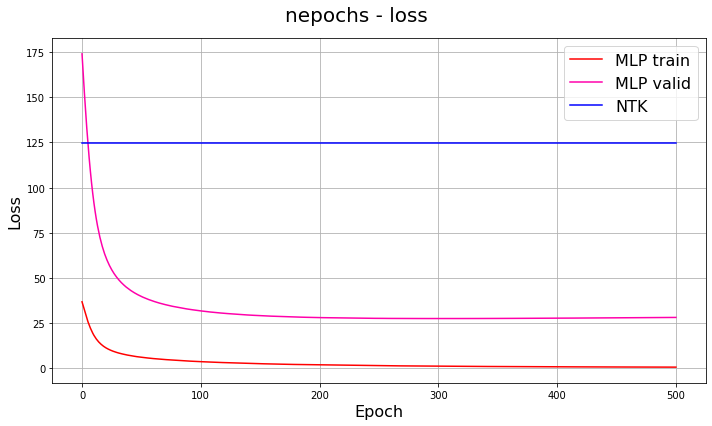

In [63]:
# loss 
if index!=2:
    pass
    # fig,ax = plt.subplots(1,1,figsize=(10,6))
    # rang  = np.linspace(0,100,100)
    # mlt   = np.mean(losstMLP,axis=(0,1))
    # slt   = np.std( losstMLP,axis=(0,1))
    # mlv   = np.mean(lossvMLP,axis=(0,1))
    # slv   = np.std( lossvMLP,axis=(0,1))
    # mlntk = np.mean(lossNTK)
    # slntk = np.std( lossNTK)

    # # MLP
    # ax.plot(rang,mlt, c="#f00", label="MLP train")
    # ax.plot(rang,mlv, c="#f0a", label="MLP valid")
    # ax.fill_between(rang,mlt-2*slt, mlt+2*slt, alpha=0.15, facecolor='#f00')
    # ax.fill_between(rang,mlv-2*slv, mlv+2*slv, alpha=0.15, facecolor='#f0a')
    # # NTK
    # # ax.axhline(mlntk, c="#00f", label="NTK")
    # ax.plot([rang[0],rang[-1]],[mlntk,mlntk], c="#00f", label="NTK")
    # ax.fill_between(rang,mlntk-2*slntk, mlntk+2*slntk, alpha=0.15, facecolor='#00f')

    # ax.set_title(name + " - loss", size=20)
    # ax.grid(True)
    # ax.set_xlabel("Epoch", fontsize = 16)
    # ax.set_ylabel("Loss",  fontsize = 16)

    # ax.legend(fontsize=16)
    # plt.tight_layout()
    # plt.savefig("loss_" + name)
    # # plt.show()
    
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    rang  = np.linspace(0,100,100)
    mlt   = np.mean(losstMLP[-1],axis=0)
    slt   = np.std( losstMLP[-1],axis=0)
    mlv   = np.mean(lossvMLP[-1],axis=0)
    slv   = np.std( lossvMLP[-1],axis=0)
    mlntk = np.mean(lossNTK[-1],axis=0)
    slntk = np.mean(lossNTK[-1],axis=0)

    # MLP
    ax.plot(rang,mlt, c="#f00", label="MLP train")
    ax.plot(rang,mlv, c="#f0a", label="MLP valid")
    # ax.fill_between(rang,mlt-2*slt, mlt+2*slt, alpha=0.15, facecolor='#f00')
    # ax.fill_between(rang,mlv-2*slv, mlv+2*slv, alpha=0.15, facecolor='#f0a')
    # NTK
    # ax.axhline(mlntk, c="#00f", label="NTK")
    ax.plot([rang[0],rang[-1]],[mlntk,mlntk], c="#00f", label="NTK")
    # ax.fill_between(rang,mlntk-2*slntk, mlntk+2*slntk, alpha=0.15, facecolor='#00f')

    ax.set_title(name + " - loss", size=20)
    ax.grid(True)
    ax.set_xlabel("Epoch", fontsize = 16)
    ax.set_ylabel("Loss",  fontsize = 16)

    ax.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig("loss_" + name)
    # plt.show()
    
    # fig,ax = plt.subplots(1,len(param_var),figsize=(20,6), sharey=True)
    # mlntk = np.mean(lossNTK)
    # slntk = np.std( lossNTK)
    # for idx in range(len(param_var)):
    #     rang  = np.linspace(0,100,100)
    #     mlt   = np.mean(losstMLP[idx],axis=0)
    #     slt   = np.std( losstMLP[idx],axis=0)
    #     mlv   = np.mean(lossvMLP[idx],axis=0)
    #     slv   = np.std( lossvMLP[idx],axis=0)
    #     # MLP
    #     ax[idx].plot(rang,mlt, c="#f00", label="MLP train")
    #     ax[idx].plot(rang,mlv, c="#f0a", label="MLP valid")
    #     ax[idx].fill_between(rang,mlt-2*slt, mlt+2*slt, alpha=0.15, facecolor='#f00')
    #     ax[idx].fill_between(rang,mlv-2*slv, mlv+2*slv, alpha=0.15, facecolor='#f0a')
    #     # NTK
    #     # ax.axhline(mlntk, c="#00f", label="NTK")
    #     ax[idx].plot([rang[0],rang[-1]],[mlntk,mlntk], c="#00f", label="NTK")
    #     ax[idx].fill_between(rang,mlntk-2*slntk, mlntk+2*slntk, alpha=0.15, facecolor='#00f')

    #     ax[idx].grid(True)
    #     # ax[idx].set_xlabel("Epoch", fontsize = 16)
    #     # ax[idx].set_ylabel("Loss",  fontsize = 16)
    # fig.suptitle(name + " - loss", size=20)

    # # ax.legend(fontsize=16)
    # plt.tight_layout()
    # plt.subplots_adjust(wspace=.1, hspace=10)
    # plt.savefig("loss_" + name)
    # # plt.show()
else:
    fig,ax = plt.subplots(1,1,figsize=(10,6), sharey=True)
    mlntk = np.mean(lossNTK)
    
    rang  = np.linspace(0,param_var[-1],param_var[-1])
    mlt   = np.mean(losstMLP[str(param_var[-1])],axis=0)
    mlv   = np.mean(lossvMLP[str(param_var[-1])],axis=0)
    # MLP
    ax.plot(rang,mlt, c="#f00", label="MLP train")
    ax.plot(rang,mlv, c="#f0a", label="MLP valid")
    # NTK
    # ax.axhline(mlntk, c="#00f", label="NTK")
    ax.plot([rang[0],rang[-1]],[mlntk,mlntk], c="#00f", label="NTK")

    ax.grid(True)
    ax.set_xlabel("Epoch", fontsize = 16)
    ax.set_ylabel("Loss",  fontsize = 16)
    fig.suptitle(name + " - loss", size=20)

    ax.legend(fontsize=16)
    plt.tight_layout()
    # plt.subplots_adjust(wspace=.1, hspace=10)
    plt.savefig("loss_" + name)
    # plt.show()


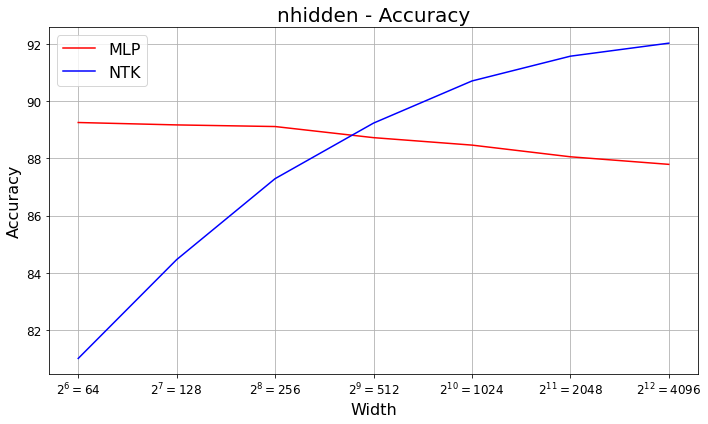

In [59]:
MLP_mean = np.mean(acc_MLP,axis=1)
MLP_std  = np.std( acc_MLP,axis=1)
NTK_mean = np.mean(acc_NTK,axis=1)
NTK_std  = np.std( acc_NTK,axis=1)

fig,ax = plt.subplots(1,1,figsize=(10,6))
# change for each test
if index == 0:
    ax.set_xlabel("Width", fontsize = 16)
    ax.set_xscale("log", base=2)
    ax.set_xticks(param_var,["$2^{%i}={%s}$" % (np.log2(i), i) for i in param_var])
    delim1 = delim2 = param_var
elif index == 1:
    ax.set_xlabel("Train size", fontsize = 16)
    ax.set_xticks(param_var)
    delim1 = delim2 = param_var
elif index == 2:
    ax.set_xlabel("Number of epochs", fontsize = 16)
    # delim1 = range(1,len(param_var)+1)
    # delim2 = range(0,len(param_var)+1)
    delim1 = param_var
    delim2 = [0] + param_var
    ax.set_xticks(delim2,["${%i}$" % i for i in [0]+param_var],rotation=90)
    # ax.set_xticks()
ax.plot(delim1,MLP_mean, c="#f00f",  label="MLP")
ax.plot(delim2,NTK_mean, c="#00ff",  label="NTK")
# ax.fill_between(delim1, MLP_mean-2*MLP_std, MLP_mean+2*MLP_std, alpha=0.15, facecolor='#f00')
# ax.fill_between(delim2, NTK_mean-2*NTK_std, NTK_mean+2*NTK_std, alpha=0.15, facecolor='#00f')
    

ax.set_title(name + " - Accuracy", size=20)
ax.set_ylabel("Accuracy", fontsize = 16)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

ax.legend(fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.savefig("acc_" + name)
# plt.show()